___
## rnn_pytorch
#### Use pytorch's nn.RNN to create predictions similar to those predicted by da_rnn.
___

### Imports

In [3]:
import torch
import torch.cuda
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch import stack as tsk #@UnresolvedImport
from torch import optim
from torch import from_numpy #@UnresolvedImport
import sys

___
### Define pytorch Module
___

In [6]:
# torch.manual_seed(1)    # reproducible

class SimpleRNN(nn.Module):
    def __init__(self,input_size,hidden_size=32):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=self.input_size,
            hidden_size=hidden_size,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(self.hidden_size, 1)

    def forward(self, x_in, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        h = None if h_state is None else from_numpy(h_state.numpy().astype(np.float32))
        x = from_numpy(x_in.numpy().astype(np.float32))
        r_out, h_state = self.rnn(x, h)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
#         return torch.stack(outs, dim=1), h_state
        return tsk(outs, dim=1), h_state


___
### Define model runner
___

In [7]:
class RnnPytorch():
    def __init__(self,
        df=None,
        reuse_indices_in_batches = True,
        epochs = 400,
        batch_size = 1, 
        time_step = 10,
        y_col = 'y',
        index_col = 'pi',
        test_percentage = .2,
        learning_rate = .02):
        

        self.epochs = epochs
        self.batch_size = batch_size
        self.time_step = time_step
        self.y_col = y_col
        self.index_col = index_col
        self.test_percentage = test_percentage

        self.df = self.default_data() if df is None else df.copy()
        x_cols = list(filter(lambda c: c!=y_col,self.df.columns.values))
        if self.index_col is not None:
            x_cols = list(filter(lambda c: c!=self.index_col, x_cols))
        self.x_cols = x_cols
        
        # create member variables
        self.rnn = SimpleRNN(len(self.x_cols))
        self.optimizer = optim.Adam(self.rnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
        self.loss_func = nn.MSELoss()
        
        
        
        self.test_size = len(self.df) - int(len(self.df) * (1-test_percentage))
        train_len = int(len(self.df) * (1-self.test_percentage))
        df_train_data = self.df.iloc[:train_len]
        
        self.training_batches = self.create_batches(df_train_data,reuse_indices_in_batches=reuse_indices_in_batches)
        dt_test_data = self.df[-self.test_size:]
        self.test_batches = self.create_test_data(dt_test_data)
        self.df_test = self.test_batches['df_test']
        pass
        
    def create_batches(self,df_train_data,reuse_indices_in_batches=True):
        # determine the label column
        lc = self.y_col
        # determine the columns that are features (x columns) and the column that will have index values
        indices = np.array(df_train_data.index)
        x_cols = self.x_cols 
        if self.index_col is not None:
#             x_cols = list(filter(lambda c: c!=self.index_col, x_cols))
            indices = np.array(df_train_data[self.index_col])
        indices = indices.reshape(-1,1)
        df_x = df_train_data[x_cols]
        df_y = df_train_data[[lc]]
        # get x and y
        x = df_x.as_matrix()
        y = df_y.as_matrix()
        # now make sure that the length of x is divisible by batch_size * time_step * x_cols
        lenx = x.shape[0]
        lenx = (lenx // (self.batch_size * self.time_step)) * (self.batch_size * self.time_step)
        
        x = x[:lenx]
        y = y[:lenx]
        indices = indices[:lenx]
        
        if reuse_indices_in_batches:
            tsgl = len(indices) -  self.time_step * self.batch_size # time step group length
            random_indices = np.random.permutation(tsgl) 
            x_time_step_groups = np.array([np.array(x[i:i+self.time_step]) for i in range(tsgl)])[random_indices]
            x_batches = np.array(x_time_step_groups).reshape(-1,self.batch_size,x_time_step_groups.shape[1],x_time_step_groups.shape[2])
            
            y_time_step_groups = np.array([y[i:i+self.time_step] for i in range(tsgl)])[random_indices]
            y_batches = np.array(y_time_step_groups).reshape(-1,self.batch_size,y_time_step_groups.shape[1],y_time_step_groups.shape[2])
            
            i_time_step_groups = np.array([indices[i:i+self.time_step] for i in range(tsgl)])[random_indices]
            i_batches = np.array(i_time_step_groups).reshape(-1,self.batch_size,i_time_step_groups.shape[1],i_time_step_groups.shape[2])
    
        else:
            x_batches = x.reshape(-1,self.batch_size,self.time_step,len(x_cols))
            y_batches = y.reshape(-1,self.batch_size,self.time_step,1)
            i_batches = indices.reshape(-1,self.batch_size,self.time_step,1)
        training_batches = {'i':i_batches,'x':x_batches,'y':y_batches}   
        
        return training_batches

    def create_test_data(self,df_test_data):
        
        # create test data to be used when plotting progress
        test_batches = self.create_batches(df_test_data,reuse_indices_in_batches=False)
        
        # create input data for creating predictions that you can plot during training
        i_batches_test = test_batches['i']
        y_actual_test = test_batches['y']
        
        # reshape your prediction batches data so that they 1 dimensional arrays that can go into the columns of a DataFrame
        i_test = i_batches_test.reshape(-1)
        y_test = y_actual_test.reshape(-1)
        
        # create DataFrame that is used for plotting during training to see progress
        df_test = pd.DataFrame({'y_actual':y_test,'y_pred':np.zeros(len(y_test))})
        # reset that DataFrame's index 
        df_test.index = i_test
        test_batches['df_test'] = df_test
        return test_batches

    def plot_it(self,executed_first_plot,h_state):
        rnn_validator = self.rnn.eval()
        x_batches_test = self.test_batches['x']
        i_batches_test = self.test_batches['i']
        # use first dimension of x_batches to get the total number of batches
        plot_steps = x_batches_test.shape[0]
        h_state_temp = h_state
        for plot_step in range(plot_steps):
            x_batch_test = x_batches_test[plot_step]
            x_batch_test_tensor = from_numpy(x_batch_test)    # shape (batch, time_step, input_size)
            test_predict,h_state_temp = rnn_validator(x_batch_test_tensor,h_state_temp)
            h_state_temp = h_state_temp.data
            y_predictions = test_predict.data.numpy().reshape(-1)
            indices_for_y_predictions = i_batches_test[plot_step].reshape(-1) 
            self.df_test.loc[indices_for_y_predictions,'y_pred'] = y_predictions
        df_display = self.df_test.iloc[-100:]
        if not executed_first_plot:
            self.line1, = self.ax.plot(df_display.index, df_display.y_actual, 'r-')
            self.line2, = self.ax.plot(df_display.index, df_display.y_pred, 'b-')
            executed_first_plot = True
        else:
            self.line1.set_ydata(df_display.y_actual)
            self.line2.set_ydata(df_display.y_pred)
            self.fig.canvas.start_event_loop(0.05)

    def default_data(self):
        time_steps = self.time_step
        epochs = self.epochs
        # show data
        steps = np.linspace(0, np.pi*epochs, epochs*time_steps, dtype=np.float32)  # float32 for converting torch FloatTensor
        x_np = np.sin(steps)
        y_np = np.cos(steps)
        dff = pd.DataFrame({'pi':steps,'x':x_np,'y':y_np})
        return dff

    def run(self):
        plt.figure(1, figsize=(12, 5))
        plt.ion()           # continuously plot
        steps = self.training_batches['i'].shape[0] 
        self.fig = plt.figure()
        self.ax = plt.gca()
        executed_first_plot=False
        
        h_state = None      # for initial hidden state
        for step in range(steps):
            
    #         i_np,x_np,y_np = create_mini_batches(batches, [step])
            i_np,x_np,y_np = self.training_batches['i'][step],self.training_batches['x'][step],self.training_batches['y'][step]
            
            x = torch.Tensor(x_np)    # shape (batch, time_step, input_size)
            y = torch.Tensor(y_np)
        
            prediction, h_state = self.rnn(x, h_state)   # rnn output
            # !! next step is important !!
            h_state = h_state.data        # repack the hidden state, break the connection from last iteration
        
            loss = self.loss_func(prediction, y)         # calculate loss
            if float(loss.data[0]<.00002):
                print(f'plotting step {step}.  loss = {loss.data[0]}')
                self.plot_it(executed_first_plot,h_state)
                executed_first_plot = True
                break
            self.optimizer.zero_grad()                   # clear gradients for this training step
            loss.backward()                         # backpropagation, compute gradients
            self.optimizer.step()                        # apply gradients
    
            if step % 20 == 0: 
                print(f'plotting step {step}.  loss = {loss.data[0]}')
                self.plot_it(executed_first_plot,h_state)
                executed_first_plot = True
                    
        print('done')
        plt.ioff()
        input('hit return to exit')


___
### Define main method
___

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:164: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:174: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


plotting step 0.  loss = 131.96463012695312
plotting step 20.  loss = 0.3230140209197998
plotting step 40.  loss = 1.608119010925293
plotting step 60.  loss = 0.40139949321746826
plotting step 80.  loss = 0.3564144968986511
plotting step 100.  loss = 0.19318625330924988
plotting step 120.  loss = 0.2653404772281647
plotting step 140.  loss = 0.23433224856853485
plotting step 160.  loss = 0.2288234531879425
plotting step 180.  loss = 0.17670859396457672
plotting step 200.  loss = 0.16198867559432983
plotting step 220.  loss = 0.2516464293003082
plotting step 240.  loss = 0.08391830325126648
plotting step 260.  loss = 0.24470007419586182
plotting step 280.  loss = 0.5800777673721313
plotting step 300.  loss = 0.48953744769096375
plotting step 320.  loss = 0.25039735436439514
plotting step 340.  loss = 0.27197763323783875
plotting step 360.  loss = 0.28841957449913025
plotting step 380.  loss = 0.17249561846256256
plotting step 400.  loss = 0.21822935342788696
plotting step 420.  loss = 0

<Figure size 864x360 with 0 Axes>

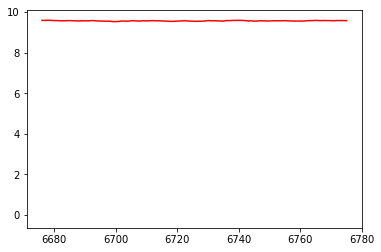

In [9]:
if __name__=='__main__':
    df_uso = pd.read_csv('./data/uso_201812.csv')
    #close    high    low    open    symbol    timestamp    tradingDay    volume
    df_uso = df_uso[['open','high','low','close','volume','tradingDay']]
    df_uso['year'] = df_uso.tradingDay.apply(lambda d:int(str(d)[0:4]))
    df_uso['month'] = df_uso.tradingDay.apply(lambda d:int(str(d)[5:7]))
    df_uso['day'] = df_uso.tradingDay.apply(lambda d:int(str(d)[8:10]))
    df_uso = df_uso[['open','high','low','close','volume','year','month','day']]
    df_uso['ic'] = df_uso.index
    df_uso['y'] = df_uso.iloc[1:].close
    df_uso = df_uso[1:]
    rnnpy = RnnPytorch(df = df_uso,index_col='ic',
                       reuse_indices_in_batches=True,epochs = 100000,batch_size=10)
#     rnnpy.df.to_csv('./df_rnn_pytorch.csv',index=False)
    rnnpy.run()

    print('done done')
